In [ ]:
!pip install pyod

In [3]:
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
import pandas as pd
import random
import numpy as np

from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
import copy

from sklearn.model_selection import train_test_split;
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import math

# 1. Exponential distribution

In [4]:
def exponen_data(lamda = 1, num = 0 , outlier=False):
  rvs =  expon.rvs(scale=1/lamda , size = num);
  df = pd.DataFrame(rvs, columns=['val'])
  if(outlier == True):
    df['Label'] = 1
  else:
    df['Label'] = 0
  return df

# 2. Gaussian distribution

In [5]:
def gaussian_data(mu, std, num, outlier):
  rvs = norm.rvs(loc = mu,scale = std ,size = num)
  df = pd.DataFrame(rvs, columns=['val']);
  if(outlier == True):
    df['Label'] = 1
  else:
    df['Label'] = 0
  return df

# 3. Uniform distribution

In [6]:
def uniform_data(llim, ulim, num, outlier):
  rvs = uniform.rvs(loc =llim , scale = (ulim+llim), size = num)
  df = pd.DataFrame(rvs, columns=['val']);
  if(outlier == True):
    df['Label'] = 1
  else:
    df['Label'] = 0
  return df

# 4. Common code

In [7]:
cont_factor = np.arange(0.02,0.12,0.02)

In [8]:
cont_factor

array([0.02, 0.04, 0.06, 0.08, 0.1 ])

In [9]:
def split_data(df):
  X = df.loc[:, df.columns != "Label"]
  y= df["Label"]
  x_train , x_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30)
  return x_train , x_test, y_train, y_test

In [10]:
def apply_anomaly_detection(x_train ,  x_test , clf):
  clf.fit(x_train.values)
  y_train_pred = clf.predict(x_train.values)
  y_test_pred = clf.predict(x_test.values) 
  #print('a')
  return y_train_pred,y_test_pred

In [11]:
def train_test_eval( y_train, y_test,y_train_pred,y_test_pred ):
  tr_prec = precision_score(y_train, y_train_pred, average='weighted')
  tr_rec = recall_score(y_train, y_train_pred, average='weighted')
  tr_acc = accuracy_score(y_train, y_train_pred, normalize=True);
  tr_f1 = f1_score(y_train, y_train_pred, average='weighted')

  tst_prec = precision_score(y_test, y_test_pred, average='weighted')
  tst_rec = recall_score(y_test, y_test_pred, average='weighted')
  tst_acc = accuracy_score(y_test, y_test_pred, normalize=True);
  tst_f1 = f1_score(y_test, y_test_pred, average='weighted')

  return tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1

In [12]:
col_list =[]
met = ['Pr', 'Re', 'Ac', 'F1']
for j in met:
  col_list.append("Tr_"+j)
  col_list.append("Te_"+j)
col_list

['Tr_Pr', 'Te_Pr', 'Tr_Re', 'Te_Re', 'Tr_Ac', 'Te_Ac', 'Tr_F1', 'Te_F1']

# Generate datasets 
1. Normal(inlier)+uniform(outlier) -> (2(algo) * 5(CF))
2. uniform(inlier)+Normal(outlier) -> (2(algo) * 5(CF))
3. Normal(inlier)+ expo(outlier) -> (2(algo) * 5(CF))
4. Expo(outlier) + Nomal(inlier) -> (2(algo) * 5(CF))
5. Expo (inlier)+ uniform(outlier) -> (2(algo) * 5(CF))
6. Uniform(inlier) + Expo(outlier) -> (2(algo) * 5(CF))

# 1. Normal(inlier)+uniform(outlier) 

In [ ]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_006', 'DF_010' ]

In [ ]:
dict_df = {}

In [ ]:
# generate datasets 
for i in range(len(cont_factor)):
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    #lst = []
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)
    
    mu = random.randint(2, 10);
    std = random.randint(1 , 30);
    df_inlier = gaussian_data(mu, std, num_inlier, False);
    #print(df_inlier)
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_outlier = uniform_data(llim, ulim, num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);


    lst.append(df);
    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


100
100
100
100
100


In [ ]:
len(dict_df['DF_004'])

100

### 1.1 OCSVM

In [ ]:
dict_eval = {}

In [ ]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


#print(lst_name)
#print(len(lst_name))



0
1
2
3
4


In [ ]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
ocsvm_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [ ]:

for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
ocsvm_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.967606,0.967541,0.967606,0.966270,0.967606,0.966270,0.967606,0.966891
1,0.04,0.938591,0.938320,0.938591,0.937123,0.938591,0.937123,0.938591,0.937701
2,0.06,0.875319,0.875463,0.889080,0.888467,0.889080,0.888467,0.881753,0.881511
3,0.08,0.874714,0.874522,0.874714,0.873560,0.874714,0.873560,0.874714,0.874017
4,0.10,0.848189,0.848918,0.848189,0.848413,0.848189,0.848413,0.848189,0.848642


In [ ]:
ocsvm_cont_results_mean.to_excel("Norm_I_Uni_O_OCSVM_CF_Mean_Prec_Expo.xlsx");

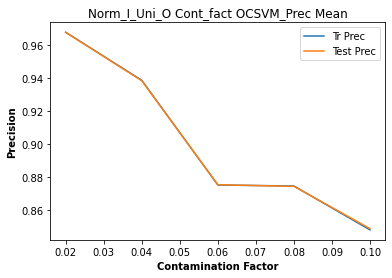

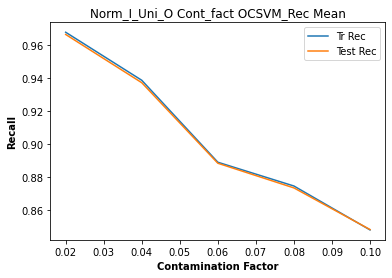

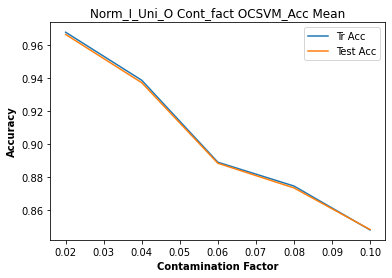

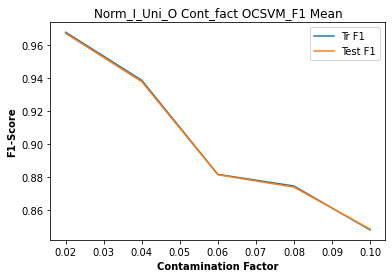

In [ ]:
plt.title("Norm_I_Uni_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_OCSVM_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Norm_I_Uni_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_OCSVM_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Uni_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_OCSVM_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Uni_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_OCSVM_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 1.2 LOF

In [ ]:
dict_eval = {}

In [ ]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


#print(lst_name)
#print(len(lst_name))



0
1
2
3
4


In [ ]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [ ]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
lof_cont_results_mean

In [ ]:
lof_cont_results_mean.to_excel("Norm_I_Uni_O_LOF_CF_Prec_Expo.xlsx");

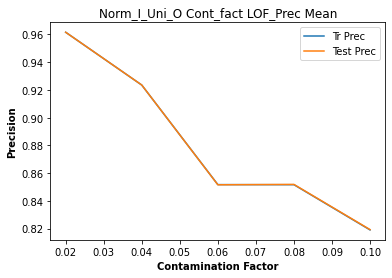

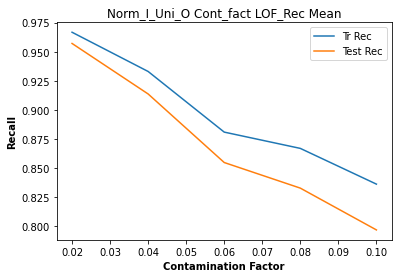

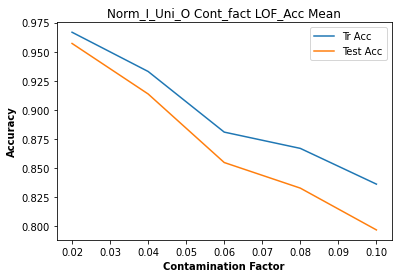

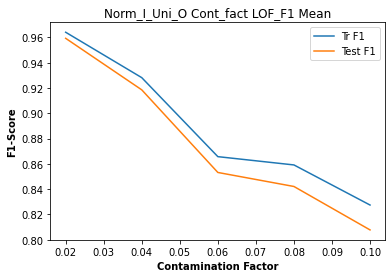

In [ ]:
plt.title("Norm_I_Uni_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_LOF_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Norm_I_Uni_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_LOF_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Uni_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_LOF_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Uni_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Uni_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

#2. uniform(inlier)+Normal(outlier)

In [ ]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_006', 'DF_010' ]

In [ ]:
dict_df = {}

In [ ]:
# generate datasets 
for i in range(len(cont_factor)):
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    #lst = []
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)
    
    mu = random.randint(2, 10);
    std = random.randint(1 , 30);
    df_outlier = gaussian_data(mu, std, num_outlier, True);
    #print(df_inlier)
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_inlier = uniform_data(llim, ulim, num_inlier, False);

    df = pd.concat([ df_outlier , df_inlier]);


    lst.append(df);
    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


100
100
100
100
100


In [ ]:
len(dict_df['DF_002'])

100

### 2.1 OCSVM

In [ ]:
dict_eval = {}

In [ ]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


#print(lst_name)
#print(len(lst_name))



0
1
2
3
4


In [ ]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
ocsvm_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [ ]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
ocsvm_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.982580,0.982678,0.982580,0.982333,0.982580,0.982333,0.982580,0.982458
1,0.04,0.966909,0.966533,0.966909,0.966243,0.966909,0.966243,0.966909,0.966347
2,0.06,0.945471,0.944727,0.949763,0.949017,0.949763,0.949017,0.946445,0.945598
3,0.08,0.932271,0.932204,0.932271,0.931657,0.932271,0.931657,0.932271,0.931876
4,0.10,0.916443,0.916629,0.916443,0.916287,0.916443,0.916287,0.916443,0.916404


In [ ]:
ocsvm_cont_results_mean.to_excel("Uni_I_Norm_O_OCSVM_CF_Mean_Prec_Expo.xlsx");

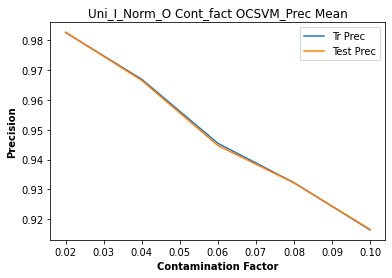

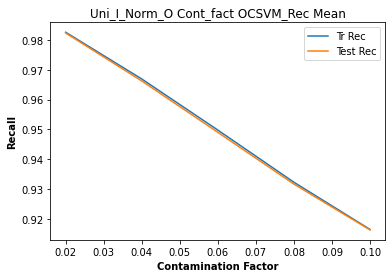

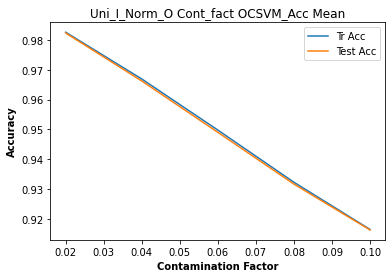

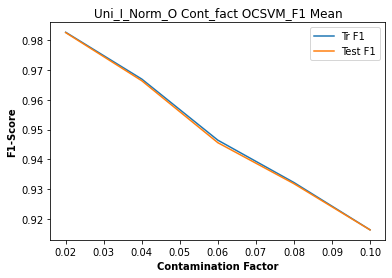

In [ ]:
plt.title("Uni_I_Norm_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_OCSVM_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Uni_I_Norm_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_OCSVM_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Norm_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_OCSVM_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Norm_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_OCSVM_CF_Mean_F1_Expo.png', bbox_inches='tight')
plt.show()

### 2.2 LOF

In [ ]:
dict_eval = {}

In [ ]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [ ]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [ ]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
lof_cont_results_mean

In [ ]:
lof_cont_results_mean.to_excel("Uni_I_Norm_O_LOF_CF_Prec_Expo.xlsx");

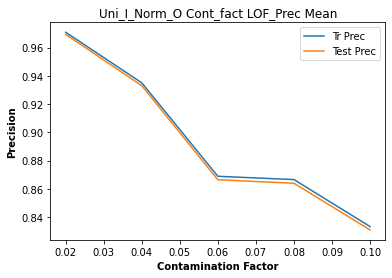

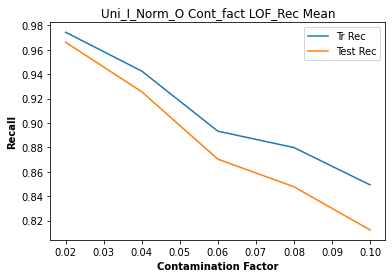

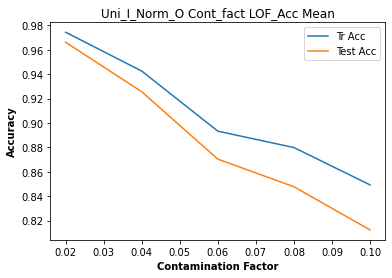

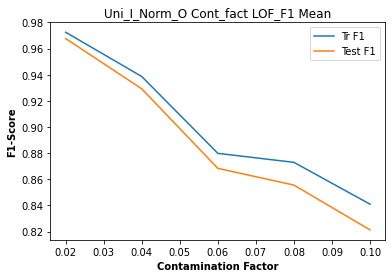

In [ ]:
plt.title("Uni_I_Norm_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_LOF_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Uni_I_Norm_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_LOF_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Norm_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_LOF_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Norm_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Norm_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

# 3  Normal(inlier)+ expo(outlier) 

In [13]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_006', 'DF_010' ]
dict_df = {}

In [14]:
# generate datasets 
for i in range(len(cont_factor)):
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    #lst = []
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)
    
    mu = random.randint(2, 10);
    std = random.randint(1 , 30);
    df_inlier = gaussian_data(mu, std, num_inlier, False);
    #print(df_inlier)
    lamda = random.randint(2, 20);
    #ulim = random.randint(15, 30);
    df_outlier = exponen_data(lamda , num_outlier , True); #uniform_data(llim, ulim, num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);


    lst.append(df);
    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


100
100
100
100
100


In [15]:
len(dict_df['DF_002'])

100

### 3.1 OCSVM

In [16]:
dict_eval = {}

In [17]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


#print(lst_name) 
#print(len(lst_name))



0
1
2
3
4


In [18]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
ocsvm_cont_results_mean['cont_fact'] = cont_factor;       
lst_mu = []  

In [19]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [20]:
ocsvm_cont_results_mean.to_excel("Norm_I_Expo_O_OCSVM_CF_Mean_Prec_Expo.xlsx"); # Normal(inlier)+ expo(outlier)

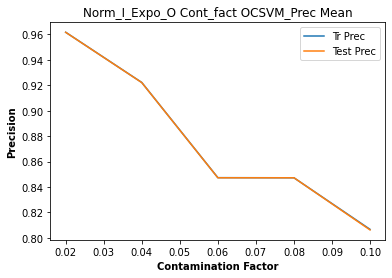

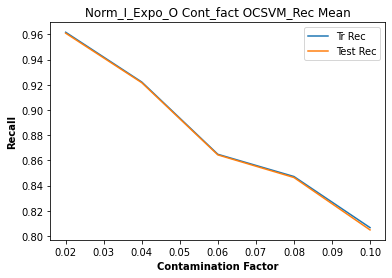

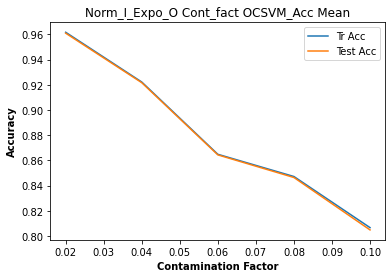

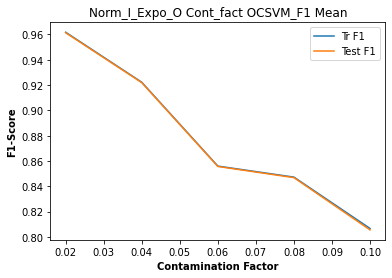

In [21]:
plt.title("Norm_I_Expo_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_OCSVM_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Norm_I_Expo_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_OCSVM_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Expo_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_OCSVM_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Expo_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_OCSVM_CF_Mean_F1_Expo.png', bbox_inches='tight')
plt.show()

### 3.2 LOF

In [22]:
dict_eval = {}

In [23]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [24]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [25]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
lof_cont_results_mean

In [27]:
lof_cont_results_mean
lof_cont_results_mean.to_excel("Norm_I_Expo_O_LOF_CF_Prec_Expo.xlsx");

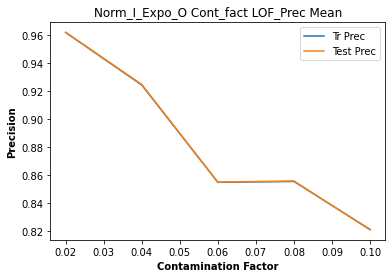

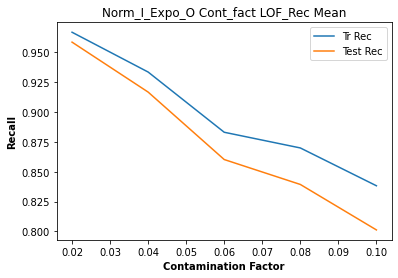

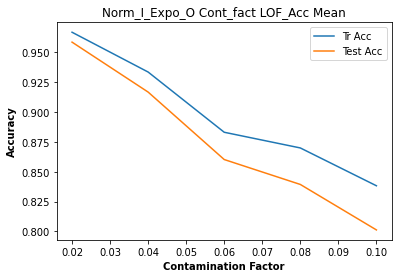

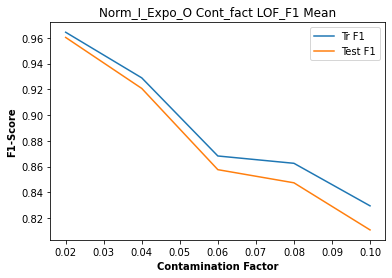

In [28]:
plt.title("Norm_I_Expo_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_LOF_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Norm_I_Expo_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_LOF_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Expo_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_LOF_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Norm_I_Expo_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Norm_I_Expo_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

# 4. Expo(inlier) + Nomal(outlier) 

In [29]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_006', 'DF_010' ]
dict_df = {}

In [30]:
# generate datasets 
for i in range(len(cont_factor)):
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    #lst = []
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)
    
    mu = random.randint(2, 10);
    std = random.randint(1 , 30);
    df_outlier = gaussian_data(mu, std, num_outlier, True);
    #print(df_inlier)
    lamda = random.randint(2, 20);
    #ulim = random.randint(15, 30);
    df_inlier = exponen_data(lamda , num_inlier , False); #uniform_data(llim, ulim, num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);


    lst.append(df);
    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


100
100
100
100
100


In [31]:
len(dict_df['DF_002'])

100

### 4.1 OCSVM

In [32]:
dict_eval = {}

In [33]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


#print(lst_name) 
#print(len(lst_name))



0
1
2
3
4


In [34]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
ocsvm_cont_results_mean['cont_fact'] = cont_factor;       
lst_mu = []  

In [35]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [36]:
ocsvm_cont_results_mean.to_excel("Expo_I_Norm_O_OCSVM_CF_Mean_Prec_Expo.xlsx"); 

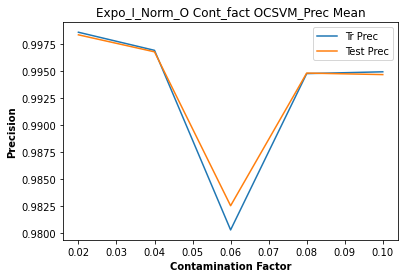

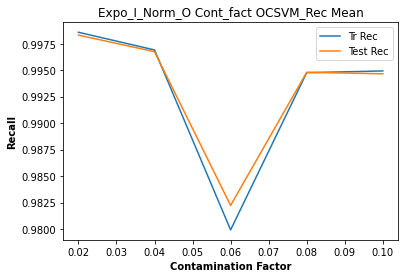

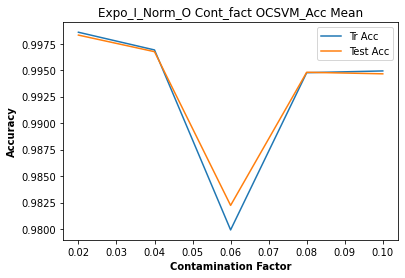

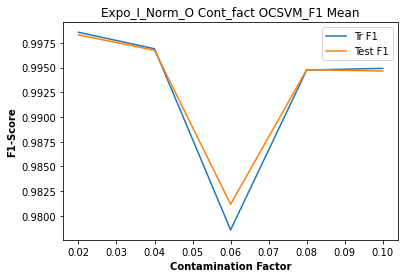

In [37]:
plt.title("Expo_I_Norm_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_OCSVM_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Expo_I_Norm_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_OCSVM_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Norm_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_OCSVM_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Norm_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_OCSVM_CF_Mean_F1_Expo.png', bbox_inches='tight')
plt.show()

### 4.2 LOF

In [38]:
dict_eval = {}

In [39]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [40]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [41]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [42]:
lof_cont_results_mean
lof_cont_results_mean.to_excel("Expo_I_Norm_O_LOF_CF_Prec_Expo.xlsx");

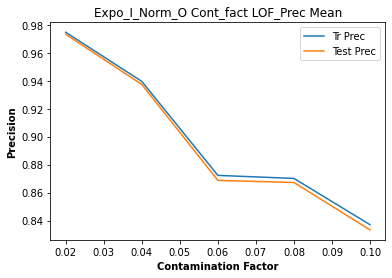

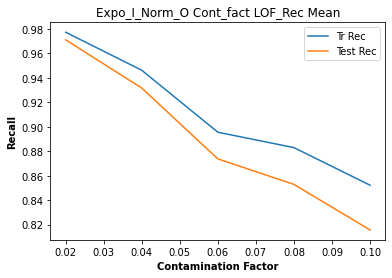

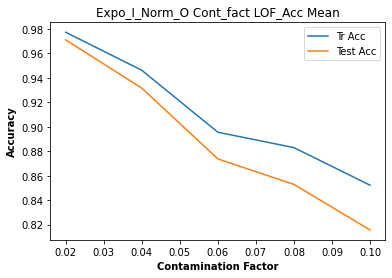

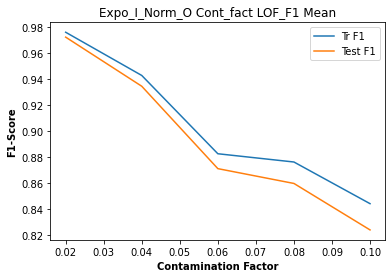

In [43]:
plt.title("Expo_I_Norm_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_LOF_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Expo_I_Norm_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_LOF_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Norm_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_LOF_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Norm_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Norm_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

# 5. Expo (inlier)+ uniform(outlier)

In [44]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_006', 'DF_010' ]
dict_df = {}

In [45]:
# generate datasets 
for i in range(len(cont_factor)):
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    #lst = []
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)
    
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_outlier = uniform_data(llim, ulim, num_outlier, True);
    #print(df_inlier)
    lamda = random.randint(2, 20);
    #ulim = random.randint(15, 30);
    df_inlier = exponen_data(lamda , num_inlier , False); #uniform_data(llim, ulim, num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);


    lst.append(df);
    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


100
100
100
100
100


In [46]:
len(dict_df['DF_002'])

100

### 5.1 OCSVM

In [47]:
dict_eval = {}

In [48]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)  


#print(lst_name) 
#print(len(lst_name))



0
1
2
3
4


In [49]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols)  
ocsvm_cont_results_mean['cont_fact'] = cont_factor;         
lst_mu = []    

In [50]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];  
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [51]:
ocsvm_cont_results_mean.to_excel("Expo_I_Uni_O_OCSVM_CF_Mean_Prec_Expo.xlsx");  # Expo (inlier)+ uniform(outlier)

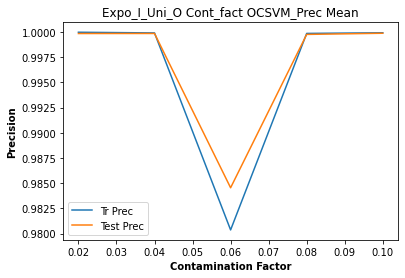

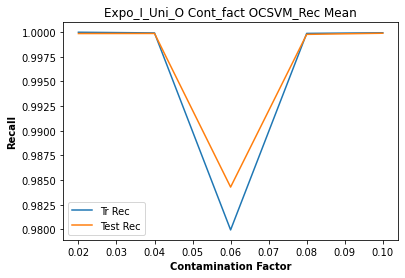

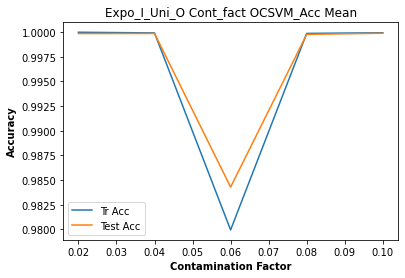

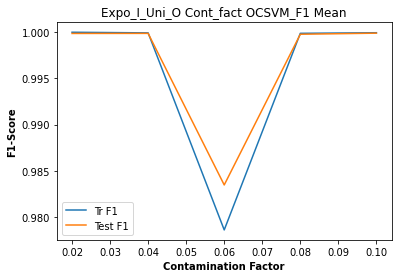

In [52]:
plt.title("Expo_I_Uni_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_OCSVM_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Expo_I_Uni_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_OCSVM_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Uni_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_OCSVM_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Uni_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_OCSVM_CF_Mean_F1_Expo.png', bbox_inches='tight')
plt.show()

### 5.2 LOF

In [53]:
dict_eval = {}

In [54]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [55]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [56]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [57]:
lof_cont_results_mean
lof_cont_results_mean.to_excel("Expo_I_Uni_O_LOF_CF_Prec_Expo.xlsx"); # Expo (inlier)+ uniform(outlier)

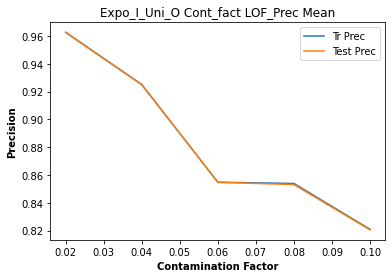

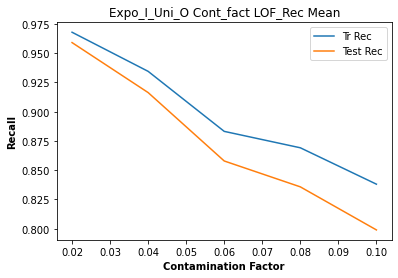

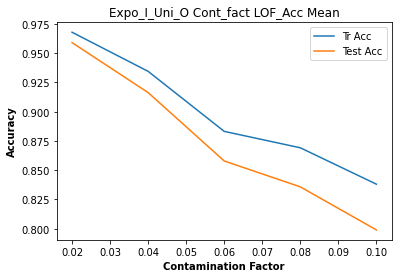

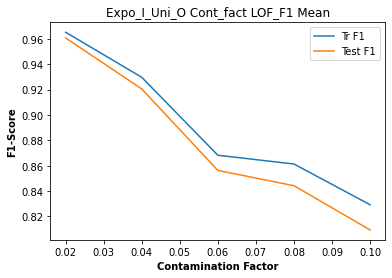

In [58]:
plt.title("Expo_I_Uni_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_LOF_CF_Mean_Prec_Expo.png', bbox_inches='tight')
plt.show()

plt.title("Expo_I_Uni_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_LOF_CF_Mean_Rec_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Uni_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_LOF_CF_Mean_Acc_Expo.png', bbox_inches='tight')
plt.show()


plt.title("Expo_I_Uni_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Expo_I_Uni_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

# 6 Uniform(inlier) + Expo(outlier)

In [59]:
df_names_list = ['DF_002', 'DF_004', 'DF_006', 'DF_006', 'DF_010' ]
dict_df = {}

In [60]:
# generate datasets 
for i in range(len(cont_factor)):
  cont = cont_factor[i];
  lst = []
  for j in range(100):
    #lst = []
    num_points = 10000;
    num_outlier = int( cont *num_points);
    #print("num_outlier: ", num_outlier)

    num_inlier = (num_points - num_outlier);
    #print("num_inlier: ", num_inlier)
    
    llim = random.randint(2, 10);
    ulim = random.randint(15, 30);
    df_inlier = uniform_data(llim, ulim, num_inlier, False);
    #print(df_inlier)
    lamda = random.randint(2, 20);
    #ulim = random.randint(15, 30);
    df_outlier = exponen_data(lamda , num_outlier , True); #uniform_data(llim, ulim, num_outlier, True);

    df = pd.concat([ df_outlier , df_inlier]);


    lst.append(df);
    
  key = df_names_list[i];
  print(len(lst))
  dict_df[key] = lst
  

    #print(df)
  #print(lst[0])


100
100
100
100
100


In [61]:
len(dict_df['DF_002'])

100

### 6.1 OCSVM

In [62]:
dict_eval = {}

In [63]:
for i in range(len(cont_factor)):
  clf = OCSVM(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    
    

    lst_name.append(temp_lst)

  df_name = "Eval_OCSVM_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


#print(lst_name) 
#print(len(lst_name))



0
1
2
3
4


In [64]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
ocsvm_cont_results_mean['cont_fact'] = cont_factor;       
lst_mu = []   

In [65]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [66]:
ocsvm_cont_results_mean.to_excel("Uni_I_Expo_O_OCSVM_CF_Mean.xlsx");  # Uniform(inlier) + Expo(outlier)

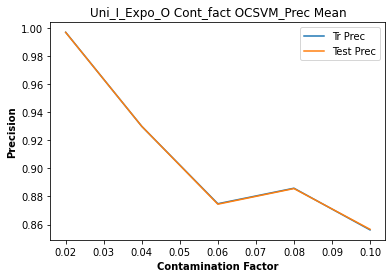

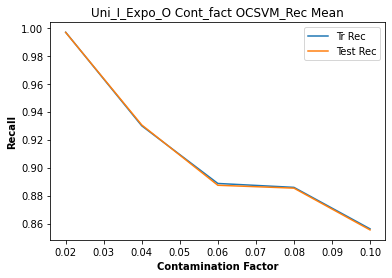

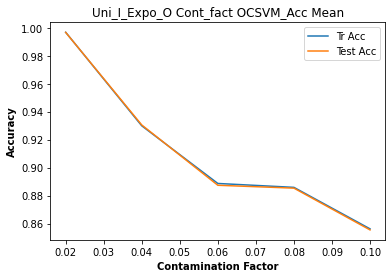

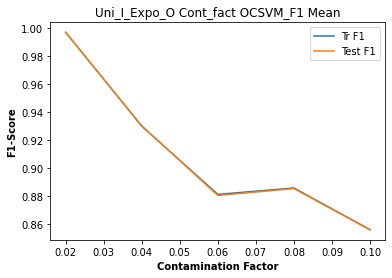

In [67]:
plt.title("Uni_I_Expo_O Cont_fact OCSVM_Prec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_OCSVM_CF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("Uni_I_Expo_O Cont_fact OCSVM_Rec Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_OCSVM_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Expo_O Cont_fact OCSVM_Acc Mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_OCSVM_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Expo_O Cont_fact OCSVM_F1 Mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_OCSVM_CF_Mean_F1.png', bbox_inches='tight')
plt.show()

### 6.2 LOF

In [68]:
dict_eval = {}   

In [69]:
for i in range(len(cont_factor)):
  clf = LOF(contamination = cont_factor[i]);
  key = df_names_list[i]
  df = copy.deepcopy(dict_df[key])
  lst_name = []
  print(i)
  for j in df:
    #print("i & j ", i,j)
    temp_lst = []
    #X = norm.rvs(loc=mu, scale=std,size=10000);
    #df = label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_LOF_"+str(round(i,3))
  dict_eval[df_name]= pd.DataFrame(lst_name, columns=col_list)


0
1
2
3
4


In [70]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols) 
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [71]:
for val in dict_eval.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    
lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [72]:
lof_cont_results_mean
lof_cont_results_mean.to_excel("Uni_I_Expo_O_LOF_CF.xlsx"); # Uniform(inlier) + Expo(outlier)

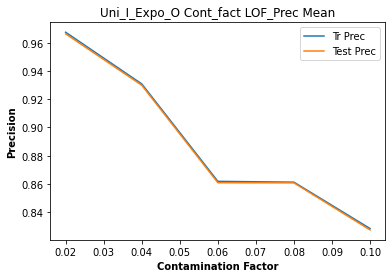

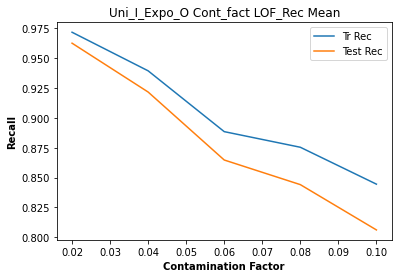

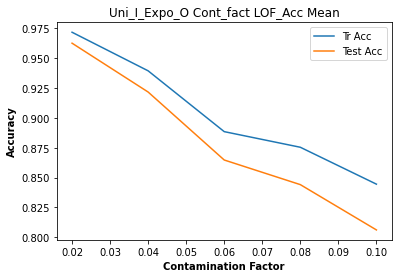

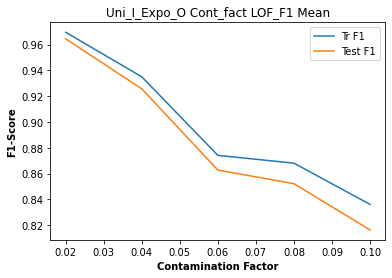

In [73]:
plt.title("Uni_I_Expo_O Cont_fact LOF_Prec Mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_LOF_CF_Mean_Prec.png', bbox_inches='tight')
plt.show()

plt.title("Uni_I_Expo_O Cont_fact LOF_Rec Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_LOF_CF_Mean_Rec.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Expo_O Cont_fact LOF_Acc Mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_LOF_CF_Mean_Acc.png', bbox_inches='tight')
plt.show()


plt.title("Uni_I_Expo_O Cont_fact LOF_F1 Mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('Uni_I_Expo_O_LOF_CF_Mean_F1.png', bbox_inches='tight')
plt.show()